# Baseline model

Just predict true if tf-idf cosin distance is closer than threshold.

This is intended for simplest end-to-end solution.

# Training-Test set setup

Dataset setup is common for all model.
Currently just put in ipynb. Please dup! (maybe factor out to .py file in the future).

In [1]:
import pandas as pd
import numpy as np

In [2]:
grants_all_df = pd.read_pickle("../data/grants_2012_from2017_xmldf.dat")

In [3]:
app_all_df = pd.read_pickle("../data/app_2017_by2012_xmldf.dat")

### Split training-test set setup

If app_id is uniq, we can just use dataframe.sample.
But somemodel might want to use multiple xml for the same app_id.

So keep all app_id in split phase.
Also, app_id order would be the same order as apply (maybe not, please confirm somebody!).
So keep order when split, Then shuffle so that every one reproduce split even though they change mind to use multiple xml of each app_id.

In [4]:
all_appid = set(app_all_df['app_id'])

In [5]:
import random

In [6]:
random.seed(1234)

In [7]:
training_id = set(random.sample(all_appid, int(len(all_appid)*0.9)))

In [8]:
testset_id = all_appid - training_id

In [9]:
len(training_id), len(testset_id)

(2769, 308)

In [10]:
training_app_df = app_all_df[app_all_df.app_id.isin(training_id)]

In [11]:
testset_app_df = app_all_df[~app_all_df.app_id.isin(training_id)]

In [12]:
app_all_df.shape, training_app_df.shape, testset_app_df.shape

((3083, 2), (2775, 2), (308, 2))

In [13]:
training_app_df.head().app_id

0    14742496
1    14348426
2    14613336
3    14053984
4    14590141
Name: app_id, dtype: int64

In [14]:
testset_app_df.iloc[1]

app_id                                             15289343
xml       <?xml version="1.0" encoding="UTF-8"?>\n<!DOCT...
Name: 15, dtype: object

In [15]:
def filter_uniq_appid(df):
    ids = set()
    filtermask = []
    for i in range(len(df)):
        app_id = df.iloc[i].app_id
        filtermask.append(app_id not in ids)
        ids.add(app_id)
    return filtermask


### Keep only first app_id

You can use multiple application xml if you want (in this case, skip filter_uniq_appid for training set).
I keep only first app_id in dataframe. I guess it in order of date, but may be not. Please confirm somebody!

In [16]:
training_app_df = training_app_df[filter_uniq_appid(training_app_df)]
testset_app_df = testset_app_df[filter_uniq_appid(testset_app_df)]

In [17]:
training_app_df.shape, testset_app_df.shape

((2769, 2), (308, 2))

### Shuffle

In [18]:
# set seed again for easier interactive shift-enter
random.seed(456)

In [19]:
training_app_df = training_app_df.sample(frac=1).reset_index(drop=True)
testset_app_df = testset_app_df.sample(frac=1).reset_index(drop=True)

### Reset index (may be you don't want, then skip here)

In [20]:
training_app_df = training_app_df.reset_index(drop=True)
testset_app_df = testset_app_df.reset_index(drop=True)

### Retrieve just claim. Remove all tags.

This utility function might necessary for any mode.

In [21]:
import re

In [22]:
CLAIM_PAT = re.compile(r'<claims[^>]*>(.*)</claims>',re.MULTILINE|re.DOTALL)

In [23]:
TAG_PAT = re.compile(r"<.*?>")

In [24]:
def whole_xml_to_claim_xml(whole):
    mat = CLAIM_PAT.search(whole)
    return mat.group(1)

In [25]:
def whole_xml_to_claim(whole):
    return TAG_PAT.sub(' ', whole_xml_to_claim_xml(whole))

# Model evaluation

In [26]:
# this is created in data_collection.ipynb
citations_2012_2017 = pd.read_pickle("../data/citations_2012_2017_merged.dat")

In [132]:
citations_2012_2017.head()

,app_id,citation_pat_pgpub_id,parsed,ifw_number,action_type,action_subtype,form892,form1449,citation_in_oa
0,12022531,8280486,8280486,NaN,NaN,NaN,1,0,0
1,12242637,8275762,8275762,NaN,NaN,NaN,0,1,0
2,12242637,8108415,8108415,NaN,NaN,NaN,0,1,0
3,12294889,8106092,8106092,NaN,NaN,NaN,0,1,0
4,12489066,8145522,8145522,NaN,NaN,NaN,0,1,0


In [155]:
len(citations_2012_2017)

6745

Unique count.

In [179]:
citations_2012_2017['app_id'].nunique()

3102

In [162]:
citations_2012_2017_ifwexist = citations_2012_2017[ ~citations_2012_2017['ifw_number'].isna() ]

In [164]:
citations_2012_2017_ifwexist.head()

,app_id,citation_pat_pgpub_id,parsed,ifw_number,action_type,action_subtype,form892,form1449,citation_in_oa
19,13024953,8212201,8212201,HQ3SCW7IPXXIFW4,103.0,a,1,0,1
24,13186063,8298268,8298268,HCUM9NCSPXXIFW4,102.0,b,1,0,1
25,13186063,8298268,8298268,HCUM9NCSPXXIFW4,103.0,a,1,0,1
26,13186063,8298268,8298268,HKV3VYS7PXXIFW4,103.0,a,1,0,1
27,13186063,8298268,8298268,HU9X0Z3GPXXIFW4,103.0,a,1,0,1


In [167]:
sum(~citations_2012_2017_ifwexist['ifw_number'].isna())

645

In [168]:
sum(~citations_2012_2017_ifwexist['action_type'].isna())

645

It seems NOT NaN ifw_number and action_type subset is about 10% of the total.  
If ifw_number exists it seems action_type also exists.

### Merge office_action data

This mere allows us to use various meta information such as action_type.

In [169]:
office_actions = pd.read_csv("../data/office_actions.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [170]:
office_actions.head()

,app_id,ifw_number,document_cd,mail_dt,art_unit,uspc_class,uspc_subclass,header_missing,fp_missing,rejection_fp_mismatch,...,rejection_103,rejection_112,rejection_dp,objection,allowed_claims,cite102_gt1,cite103_gt3,cite103_eq1,cite103_max,signature_type
0,14150981,100867762,CTFR,2015-10-15,2632,375,219000,0,0,0,...,1,0,0,0,0,0,0,1,2,1
1,14198961,100867788,CTFR,2015-10-15,2699,345,173000,0,0,0,...,1,0,0,0,0,0,0,0,2,1
2,13796589,100867794,CTNF,2015-10-15,3776,606,159000,0,0,0,...,1,0,0,0,0,0,0,0,3,3
3,14673475,100867844,CTNF,2015-10-15,2627,345,175000,0,0,0,...,1,1,1,0,0,0,1,0,4,1
4,14669113,100867850,CTNF,2015-10-15,2666,382,118000,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [171]:
citations_2012_2017_with_OA = pd.merge(citations_2012_2017_ifwexist, office_actions, on='ifw_number', how='left')

In [172]:
citations_2012_2017_with_OA.head()

,app_id_x,citation_pat_pgpub_id,parsed,ifw_number,action_type,action_subtype,form892,form1449,citation_in_oa,app_id_y,...,rejection_103,rejection_112,rejection_dp,objection,allowed_claims,cite102_gt1,cite103_gt3,cite103_eq1,cite103_max,signature_type
0,13024953,8212201,8212201,HQ3SCW7IPXXIFW4,103.0,a,1,0,1,13024953,...,1,1,0,1,0,0,0,1,3,1
1,13186063,8298268,8298268,HCUM9NCSPXXIFW4,102.0,b,1,0,1,13186063,...,1,1,0,0,0,0,0,0,2,3
2,13186063,8298268,8298268,HCUM9NCSPXXIFW4,103.0,a,1,0,1,13186063,...,1,1,0,0,0,0,0,0,2,3
3,13186063,8298268,8298268,HKV3VYS7PXXIFW4,103.0,a,1,0,1,13186063,...,1,0,0,0,0,0,0,0,3,2
4,13186063,8298268,8298268,HU9X0Z3GPXXIFW4,103.0,a,1,0,1,13186063,...,1,0,0,0,0,0,1,0,4,2


In [176]:
citations_2012_2017_with_OA['action_type'].value_counts()

103.0    500
102.0    145
Name: action_type, dtype: int64

Note that action type means:

> 101 Rejection – Subject Matter Eligibility, Statutory Double Patenting, Utility, etc

> 102 Rejection – Lack of Novelty

> 103 Rejection – Obviousness

Count unique num.

In [178]:
citations_2012_2017_with_OA['app_id_x'].nunique()

471

In [342]:
app_id_with_102 = set( citations_2012_2017_with_OA[ citations_2012_2017_with_OA['action_type'] == 102 ].app_id_x )
app_id_with_103 = set( citations_2012_2017_with_OA[ citations_2012_2017_with_OA['action_type'] == 103 ].app_id_x )

### Create label df

We will create create label df which is app_id - cited grant-id (denoted as parsed) matrix.  
This will be a test set so we will use only test subset.

In [133]:
def set_one_answer_appid(labeldf, oneappid):
    cited_patids = citations_2012_2017[citations_2012_2017.app_id == oneappid].parsed
    labeldf.loc[oneappid] = labeldf.columns.isin(cited_patids)

In [134]:
def create_label_df():
    label_df = pd.DataFrame(columns=grants_all_df.parsed.values, dtype=np.bool)
    for appid in testset_app_df.app_id:
        set_one_answer_appid(label_df, appid)
    return label_df

In [135]:
label_df = create_label_df()

In [136]:
label_df.shape

(308, 5424)

In [137]:
label_df.head()

,8245358,8245460,8245733,8245746,8245764,8245780,8245893,8245898,8245901,8245943,...,8341338,8341346,8341427,8341429,8341430,8341457,8341538,8341573,8341732,8341749
14048515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15112855,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14022100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15089692,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15292702,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Cofirm label df is correct

In [31]:
testset_app_df.head()

,app_id,xml
0,14048515,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1,15112855,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
2,14022100,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
3,15089692,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
4,15292702,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."


In [182]:
label_df.head()

,8245358,8245460,8245733,8245746,8245764,8245780,8245893,8245898,8245901,8245943,...,8341338,8341346,8341427,8341429,8341430,8341457,8341538,8341573,8341732,8341749
14048515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15112855,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14022100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15089692,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15292702,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [183]:
label_df.loc[15289843].idxmax()

8233452

In [184]:
citations_2012_2017[citations_2012_2017["app_id"]==15289843].parsed

6092    8270369
6094    8204029
6095    8233452
Name: parsed, dtype: object

In [185]:
label_df.loc[15289843].loc[8270369]

True

In [186]:
label_df.loc[15289843].sum()

3

### Predict test set and print summary

In [187]:
def predict_training_set(predict_func):
    """
    predict_func(claims) return NxM of boolean. N is len(claims). M is rownum of grants_all_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    predictdf = pd.DataFrame(columns=grants_all_df.parsed.values, dtype=np.bool)
    res = predict_func(testset_app_df["xml"].map(whole_xml_to_claim))
    for idx, appid in enumerate(testset_app_df.app_id):
        predictdf.loc[appid] = res[idx, :]
    """
        one_res = predict_func(whole_xml_to_claim(testset_app_df[testset_app_df.app_id == appid]["xml"].iloc[0]))
        predictdf.loc[appid] = one_res
    """
    return predictdf

In [188]:
def calc_TPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_FPs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]]) for one_appid in testset_app_df.app_id])

def calc_TNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][~labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_FNs(preddf, labeldf):
    return sum([sum(preddf.loc[one_appid][labeldf.loc[one_appid]] == False) for one_appid in testset_app_df.app_id])

def calc_TFPNs(preddf, labeldf):
    return calc_TPs(preddf, labeldf), calc_FPs(preddf, labeldf), calc_TNs(preddf, labeldf), calc_FNs(preddf, labeldf)

In [189]:
def calc_summary_TFPNs(TP, FP, TN, FN):
    "return acc, prec, recall, f1."
    return pd.DataFrame(columns=["acc", "prec", "recall", "f1"], data=[[(TP+TN)/(TP+FP+TN+FN), TP/(TP+FP), TP/(TP+FN), 2*TP/(2*TP+FP+FN)]])
    
def calc_summary(preddf, labeldf):
    TP, FP, TN, FN = calc_TFPNs(preddf, labeldf)
    return calc_summary_TFPNs(TP, FP, TN, FN)

### Sample evaluation code for baseline model

predict_tfidf_model is defined below

In [130]:
pred_df = predict_training_set(predict_tfidf_model)

In [131]:
calc_summary(pred_df, label_df)

,acc,prec,recall,f1
0,0.906713,0.003739,0.726368,0.007439


# Start baseline model dependent code from here

Now common part is done.
Start model specific cells.

In [190]:
grants_all_df.head()["xml"].map(whole_xml_to_claim)

0    \n \n 1. A pacifier clip, comprising:\n a base...
1    \n \n 1. A supporting clasp which supports a s...
2    \n \n 1. A clip of molded plastics material fo...
3    \n \n 1. A tire inflation system comprising:\n...
4    \n \n 1. A cooling system for a heat-generatin...
Name: xml, dtype: object

In [191]:
grants_all_df["claim"] = grants_all_df["xml"].map(whole_xml_to_claim)

In [192]:
grants_all_df.head()

,parsed,xml,claim
0,8245358,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","\n \n 1. A pacifier clip, comprising:\n a base..."
1,8245460,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1. A supporting clasp which supports a s...
2,8245733,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1. A clip of molded plastics material fo...
3,8245746,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1. A tire inflation system comprising:\n...
4,8245764,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1. A cooling system for a heat-generatin...


# Convert to feature vectors and retrieve vocabulary

Doing similar things to scikit learn example  
http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

Also, this document is helpful.  
http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

## (only once) Calculate tf-idf for grants2012

In [194]:
random.seed(1234)

In [195]:
vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.5)

In [196]:
grants_features = vectorizer.fit_transform(grants_all_df["claim"])

In [197]:
grants_features.shape

(5424, 28988)

In [198]:
vocab = vectorizer.vocabulary_

In [199]:
idfvec = vectorizer.idf_

In [200]:
len(vocab.keys())

28988

In [220]:
list(vocab.items())[0:5]

[('tetrahydrofuran', 25804),
 ('767', 846),
 ('spliced', 24270),
 ('nucleants', 17658),
 ('fplc', 11161)]

In [221]:
len(idfvec)

28988

In [222]:
idfvec[0:5]

array([ 7.51933164,  5.26803984,  8.905626  ,  8.905626  ,  8.905626  ])

### (only once) Save features, vocabulary, idf vector

In [55]:
import pickle

In [56]:
with open("../data/grants2012_tfidf_features.dat", "wb") as f:
    pickle.dump(grants_features, f)

In [57]:
with open("../data/grants2012_vocab_idf_dict.dat", "wb") as f:
    pickle.dump({"vocabulary": vocab, "idf": idfvec}, f)

### Load code

In [223]:
import pickle

In [224]:
with open("../data/grants2012_tfidf_features.dat", 'rb') as f:
    grants_features = pickle.load(f)

In [225]:
with open("../data/grants2012_vocab_idf_dict.dat", 'rb') as f:
    dic = pickle.load(f)
    vocab, idfvec = dic["vocabulary"], dic["idf"]

### Calculate tf-idf manually using vocabulary and idf vector, and check whether the result is identical to that of TfidfVectorizer.

In [226]:
from sklearn.feature_extraction.text import CountVectorizer

In [227]:
one_claim = grants_all_df.iloc[0]["claim"]

In [228]:
count_vec = CountVectorizer(vocabulary=vocab, stop_words="english", max_df = 0.5)

In [260]:
res = count_vec.fit_transform([one_claim])

In [261]:
res_arr = res.toarray()

In [262]:
res.shape

(1, 28988)

In [263]:
tf = res_arr[0]

In [264]:
answer = grants_features[0, :].toarray()

In [265]:
answer = answer[0]

In [266]:
def print_nonzero_index(arr, maxcount):
    count = 0

    for i, v in enumerate(arr):
        if v != 0:
            count+=1
            print(i)
            if count > maxcount:
                break

In [267]:
print_nonzero_index(answer, 5)

1025
1072
1073
1117
1120
1373


In [268]:
answer[1025]

0.015374346416530774

In [269]:
print_nonzero_index(tf, 5)

1025
1072
1073
1117
1120
1373


In [270]:
sumtf = sum(tf)

In [271]:
unnormalized = [tf[i]*idfvec[i]/sumtf for i, _ in enumerate(tf)]

In [273]:
unnormalized[1025]

0.0094835279286488317

In [272]:
unnormalized[1025]/np.linalg.norm(unnormalized)

0.015374346416530772

Try two claim for generarization

In [274]:
tfcsr = count_vec.fit_transform(grants_all_df.iloc[0:2]["claim"])

In [275]:
tf = tfcsr.toarray()

In [276]:
tf.shape

(2, 28988)

In [277]:
unnormalized = np.multiply(tf, idfvec)

In [278]:
lpnorms = np.linalg.norm(unnormalized, axis=1)

In [279]:
manual_tfidf = unnormalized/lpnorms[:, np.newaxis]

In [280]:
manual_tfidf[0, 1025]

0.015374346416530776

In [281]:
all(abs(manual_tfidf[0, :] - grants_features[0].toarray()[0]) < 0.00001)

True

In [282]:
all(abs(manual_tfidf[1] - grants_features[1].toarray()[0]) < 0.00001)

True

Now make calculate tf-idf function

In [283]:
def claims_to_tfidfs(claimarr, count_vec, idfvec):
    tfcsr = count_vec.fit_transform(claimarr)
    tf = tfcsr.toarray()
    unnormalized = np.multiply(tf, idfvec)
    lpnorms = np.linalg.norm(unnormalized, axis=1)
    return unnormalized/lpnorms[:, np.newaxis]

In [284]:
manu3 = claims_to_tfidfs(grants_all_df.iloc[0:2]["claim"], count_vec, idfvec)

In [285]:
all(manu3[0] == manual_tfidf[0]), all(manu3[1] == manual_tfidf[1])

(True, True)

### It's time to calculate tfidf for training set.

In [286]:
training_app_df["claim"] = training_app_df["xml"].map(whole_xml_to_claim)

In [287]:
training_features = claims_to_tfidfs(training_app_df["claim"], count_vec, idfvec)

Calculate one cosine distance

In [288]:
one_appid = training_app_df.iloc[0].app_id

In [289]:
citations_2012_2017[citations_2012_2017.app_id == one_appid]

,app_id,citation_pat_pgpub_id,parsed,ifw_number,action_type,action_subtype,form892,form1449,citation_in_oa
105,14101171,8308754,8308754,NaN,NaN,NaN,0,1,0
108,14101171,8114114,8114114,NaN,NaN,NaN,0,1,0
492,14101171,8100958,8100958,NaN,NaN,NaN,0,1,0
493,14101171,8226704,8226704,NaN,NaN,NaN,0,1,0
494,14101171,8110267,8110267,NaN,NaN,NaN,0,1,0
495,14101171,8142456,8142456,NaN,NaN,NaN,0,1,0
496,14101171,8328840,8328840,NaN,NaN,NaN,0,1,0
497,14101171,8333796,8333796,NaN,NaN,NaN,0,1,0
498,14101171,8226679,8226679,NaN,NaN,NaN,0,1,0
499,14101171,8323350,8323350,NaN,NaN,NaN,0,1,0


In [290]:
answer_patids = set(citations_2012_2017[citations_2012_2017.app_id == one_appid].parsed.astype(int))

In [291]:
answer_patids

{8100958,
 8110267,
 8114114,
 8142456,
 8162970,
 8226679,
 8226704,
 8308754,
 8323305,
 8323350,
 8328840,
 8333783,
 8333796}

In [292]:
type(grants_all_df.iloc[0].parsed)

numpy.int64

In [293]:
answer_idxs = grants_all_df[grants_all_df.parsed.isin(answer_patids)].index

In [294]:
answer_idxs[0]

1133

In [295]:
grants_all_df.iloc[2570].parsed

8172557

In [296]:
answer_patent_features = grants_features[answer_idxs[0], :].toarray()[0]

In [297]:
import scipy

In [299]:
scipy.spatial.distance.cdist(
    training_features[0, :][np.newaxis, :]
    , grants_features[answer_idxs[0], :].toarray()
    , 'cosine')

array([[ 0.80908445]])

### Calculate 20 cosine distance

In [300]:
training_app_df.head()

,app_id,xml,claim
0,14101171,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","\n \n 1 . A material delivery device, compris..."
1,15299078,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1 . (canceled) \n \n \n 2 . A method e...
2,15208119,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","\n \n 1 . In a data visualization system, exe..."
3,14863698,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...",\n \n 1 . A process to produce a supported ca...
4,15233701,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","\n \n 1 . An absorbent microstructure array, ..."


In [301]:
training_app_df[training_app_df.app_id == 15227804].index[0]

1416

In [325]:
def calc_cosin_for_one_app(appid):
    '''
    Calculate cosine distances between a given application id in 2017 and cited grants patents in 2012.
    '''
    answer_patids = set(citations_2012_2017[citations_2012_2017.app_id == appid].parsed.astype(int))
    answer_idxs = grants_all_df[grants_all_df.parsed.isin(answer_patids)].index
    answer_patent_features = grants_features[answer_idxs, :].toarray()
    training_features_idx = training_app_df[training_app_df.app_id == appid].index[0]
    return scipy.spatial.distance.cdist(training_features[training_features_idx, :][np.newaxis, :]
                                        , answer_patent_features
                                        , 'cosine')[0]


In [315]:
set(citations_2012_2017[citations_2012_2017.app_id == training_app_df[0:1].app_id.values[0]].parsed.astype(int))

{8100958,
 8110267,
 8114114,
 8142456,
 8162970,
 8226679,
 8226704,
 8308754,
 8323305,
 8323350,
 8328840,
 8333783,
 8333796}

In [316]:
training_app_df[0:1].app_id.values

array([14101171])

In [105]:
calc_cosin_for_one_app(14575586)

array([ 0.93692449])

In [106]:
calc_cosin_for_one_app(15239553)

array([ 0.70069898])

In [107]:
[calc_cosin_for_one_app(appid) for appid in training_app_df[0:20].app_id]

[array([ 0.80908445,  0.96978936,  0.94034034,  0.91921866,  0.90013086,
         0.87894427,  0.92356115,  0.82760179,  0.75783726,  0.90312825,
         0.97723739,  0.76761425,  0.90077301]),
 array([ 0.9214074]),
 array([ 0.97823545]),
 array([ 0.48991428]),
 array([ 0.96830759,  0.98131996,  0.96913659,  0.96015407,  0.97320756,
         0.99110994,  0.98729205,  0.93793983,  0.99784602]),
 array([ 0.54758072]),
 array([ 0.73163111,  0.86353843]),
 array([ 0.64070774,  0.98536945,  0.78906306]),
 array([ 0.84117558]),
 array([ 0.4039773]),
 array([ 0.62516921,  0.45756549]),
 array([ 0.8716739]),
 array([ 0.95036339,  0.91516744]),
 array([ 0.95695054]),
 array([ 0.56269703,  0.50022958,  0.32050034,  0.99982104,  0.51788965]),
 array([ 0.80745739,  0.76296022,  0.87023973,  0.92690423]),
 array([ 0.91334567]),
 array([ 0.97716946]),
 array([ 0.6810825]),
 array([ 0.78845391,  0.66503902,  0.8283928 ])]

In [108]:
calc_cosin_for_one_app(training_app_df.iloc[5].app_id)

array([ 0.54758072])

In [109]:
calc_cosin_for_one_app(training_app_df.iloc[5].app_id).mean() < 0.95

True

### Calculate the averages of cosine distances between {all app, app with action type 102, app with action type 103} and cited patents for those applications.

#### All training set.

In [336]:
%matplotlib inline
import matplotlib.pyplot as plt

In [330]:
%%time
cosdis_all_tr = [calc_cosin_for_one_app(appid) for appid in training_app_df.app_id]

Flatten the list.

In [331]:
cosdis_all_tr = np.concatenate(cosdis_all_tr).ravel()

In [333]:
np.mean(cosdis_all_tr)

0.8016396495275282

In [334]:
np.median(cosdis_all_tr)

0.85400296567096656

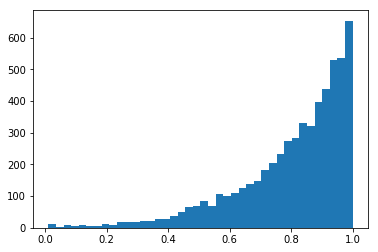

In [338]:
plt.hist(cosdis_all_tr, bins='auto')
plt.show()

#### Training subset with action type == 102.

In [347]:
len( set(training_app_df.app_id) & app_id_with_102 )

117

In [349]:
cosdis_tr_102 = [calc_cosin_for_one_app(appid) for appid in set(training_app_df.app_id) & app_id_with_102]

In [350]:
cosdis_tr_102 = np.concatenate(cosdis_tr_102).ravel()

In [351]:
np.mean(cosdis_tr_102)

0.78873483830333047

In [352]:
np.median(cosdis_tr_102)

0.86290117740702055

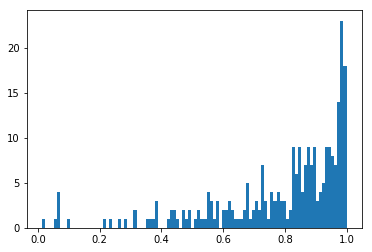

In [354]:
plt.hist(cosdis_tr_102, bins=100)
plt.show()

#### Training subset with action type == 103.

In [348]:
len( set(training_app_df.app_id) & app_id_with_103 )

350

In [355]:
cosdis_tr_103 = [calc_cosin_for_one_app(appid) for appid in set(training_app_df.app_id) & app_id_with_103]

In [356]:
cosdis_tr_103 = np.concatenate(cosdis_tr_103).ravel()

In [357]:
np.mean(cosdis_tr_103)

0.79312111371313654

In [358]:
np.median(cosdis_tr_103)

0.83713146196826438

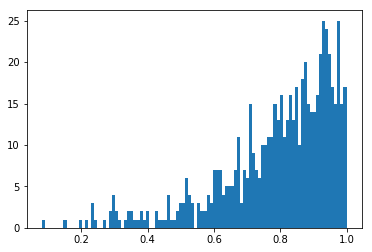

In [359]:
plt.hist(cosdis_tr_103, bins=100)
plt.show()

### Compare with random pair cosdistance

In [317]:
training_features.shape

(2769, 28988)

In [318]:
grants_features.shape

(5424, 28988)

In [323]:
scipy.spatial.distance.cdist(training_features[0:10, :], grants_features[0:10, :].toarray(), 'cosine')

array([[ 0.97569918,  0.95249141,  0.98411699,  0.93277802,  0.96882411,
         0.94234083,  0.94379522,  0.970841  ,  0.94759347,  0.99821494],
       [ 0.99831205,  0.99363558,  0.99961919,  0.99399185,  0.99060848,
         0.9505885 ,  0.99260527,  0.99914325,  0.99323332,  0.97848298],
       [ 0.99980987,  0.99393998,  0.99958451,  0.99619836,  0.99436212,
         0.96020493,  0.99561622,  0.99769519,  0.99446799,  0.99839842],
       [ 0.99586026,  0.99686952,  0.99900718,  0.99215062,  0.99983183,
         0.97660755,  0.99880718,  0.99984287,  0.96035566,  1.        ],
       [ 0.99317543,  0.98478462,  0.98244929,  0.97780866,  0.99105318,
         0.96993462,  0.9904048 ,  0.99628931,  0.97663771,  0.99280778],
       [ 0.9987414 ,  0.99683919,  0.99661115,  0.99385992,  0.99542386,
         0.93313082,  0.99833579,  0.99977667,  0.99863384,  0.98997338],
       [ 0.99728799,  0.99901508,  0.9990166 ,  0.99851133,  0.99489464,
         0.98128149,  0.9975588 ,  0.99289233

In [111]:
training_features = claims_to_tfidfs(training_app_df["claim"], count_vec, idfvec)

In [112]:
grants_features_arr = grants_features.toarray()

In [113]:
TFIDF_MODEL_THRESHOLD=0.95
# TFIDF_MODEL_THRESHOLD=0.8

def predict_tfidf_model(claims):
    """
    return: NxM of boolean. N is len(claims). M is rownum of grants_all_df.
            value indicate n claim is cite patent of m row of grants_all_df.
    """
    features = claims_to_tfidfs(claims, count_vec, idfvec)
    dists = scipy.spatial.distance.cdist(features, grants_features_arr, 'cosine')
    return dists < TFIDF_MODEL_THRESHOLD


### Calc recall of 100

In [114]:
res = predict_tfidf_model(training_app_df[0:100]["claim"])

In [115]:
res.shape

(100, 5424)

In [116]:
all_pred_of_labeltrue = np.array([], dtype=np.bool)

In [117]:
for idx in range(0, 100):
    one_appid = training_app_df.iloc[idx].app_id
    pred_oneres = res[idx]
    label_patids = citations_2012_2017[citations_2012_2017.app_id == one_appid].parsed
    label_idxs = grants_all_df.parsed[grants_all_df.parsed.isin(label_patids)].index
    pred_of_labeltrue = pred_oneres[label_idxs]
    all_pred_of_labeltrue = np.concatenate([all_pred_of_labeltrue, pred_of_labeltrue])

In [118]:
sum(all_pred_of_labeltrue)/len(all_pred_of_labeltrue)

0.75600000000000001

### Check result by hand (seems correct)

In [119]:
training_app_df.iloc[0]

app_id                                             14101171
xml       <?xml version="1.0" encoding="UTF-8"?>\n<!DOCT...
claim     \n \n  1 . A material delivery device, compris...
Name: 0, dtype: object

In [120]:
pred_oneres = res[0]

In [121]:
pred_oneres.sum()

646

In [122]:
citations_2012_2017[citations_2012_2017.app_id == 15267723].parsed

5510    8172557
Name: parsed, dtype: object

In [123]:
grants_all_df.parsed[grants_all_df.parsed == 8172557].index

Int64Index([2570], dtype='int64')

In [124]:
pred_oneres[2570]

False

### Why test set recall is so bad?

In [125]:
res = predict_tfidf_model(testset_app_df["xml"].map(whole_xml_to_claim))

In [126]:
testset_app_df.shape

(308, 2)

In [127]:
all_pred_of_labeltrue = np.array([], dtype=np.bool)

In [128]:
for idx in range(0, testset_app_df.shape[0]):
    one_appid = testset_app_df.iloc[idx].app_id
    pred_oneres = res[idx]
    label_patids = citations_2012_2017[citations_2012_2017.app_id == one_appid].parsed
    label_idxs = grants_all_df.parsed[grants_all_df.parsed.isin(label_patids)].index
    pred_of_labeltrue = pred_oneres[label_idxs]
    all_pred_of_labeltrue = np.concatenate([all_pred_of_labeltrue, pred_of_labeltrue])

In [129]:
sum(all_pred_of_labeltrue)/len(all_pred_of_labeltrue)

0.72636815920398012

# Trial-and-Errors

In [6]:
grants_all_df.head()

,parsed,xml
0,8245358,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1,8245460,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
2,8245733,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
3,8245746,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
4,8245764,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."


In [8]:
grants_all_df['xml'][0]

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE us-patent-grant SYSTEM "us-patent-grant-v42-2006-08-23.dtd" [ ]>\n<us-patent-grant lang="EN" dtd-version="v4.2 2006-08-23" file="US08245358-20120821.XML" status="PRODUCTION" id="us-patent-grant" country="US" date-produced="20120806" date-publ="20120821">\n<us-bibliographic-data-grant>\n<publication-reference>\n<document-id>\n<country>US</country>\n<doc-number>08245358</doc-number>\n<kind>B2</kind>\n<date>20120821</date>\n</document-id>\n</publication-reference>\n<application-reference appl-type="utility">\n<document-id>\n<country>US</country>\n<doc-number>12854801</doc-number>\n<date>20100811</date>\n</document-id>\n</application-reference>\n<us-application-series-code>12</us-application-series-code>\n<us-term-of-grant>\n<us-term-extension>1</us-term-extension>\n</us-term-of-grant>\n<classifications-ipcr>\n<classification-ipcr>\n<ipc-version-indicator><date>20060101</date></ipc-version-indicator>\n<classification-level>A</classificatio

In [7]:
app_all_df.head()

,app_id,xml
0,14742496,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1,14348426,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
2,14613336,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
3,14053984,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
4,14590141,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."


In [15]:
all_appid

{14794752,
 15360001,
 14188550,
 15278087,
 15278093,
 14802959,
 14876688,
 15196179,
 15155223,
 15155226,
 14999579,
 15089692,
 15147039,
 14934049,
 15220772,
 15155236,
 15228967,
 15155246,
 14811183,
 14884916,
 15360053,
 15228983,
 15335482,
 14794819,
 15097926,
 15204427,
 14794828,
 14819405,
 15278171,
 15360092,
 15056989,
 14803038,
 15245414,
 15204455,
 14860393,
 14844009,
 15278188,
 14794862,
 15278195,
 14794871,
 14794875,
 15065211,
 15245438,
 14803071,
 14803075,
 14811269,
 15278213,
 14262407,
 15122569,
 14213259,
 15130764,
 14803084,
 15114383,
 14794901,
 14205081,
 15253660,
 15270045,
 15122589,
 14811296,
 14811297,
 14205097,
 15335593,
 15114412,
 15114417,
 14811314,
 15073459,
 14926006,
 14852284,
 14590141,
 14016704,
 15278272,
 14860483,
 15302857,
 14885065,
 14803152,
 15286487,
 15294683,
 14778588,
 14811362,
 15261926,
 14819559,
 14803181,
 14811374,
 15335661,
 14803184,
 14794996,
 14794997,
 15073525,
 14983412,
 15270145,
 15278339,

Check vocab.

In [206]:
sorted(vocab.items(), key=lambda x: x[1])[:20]

[('00', 0),
 ('000', 1),
 ('0000001', 2),
 ('000005', 3),
 ('00002', 4),
 ('00005', 5),
 ('0001', 6),
 ('00015', 7),
 ('00015and', 8),
 ('00019', 9),
 ('0002', 10),
 ('00025', 11),
 ('0003', 12),
 ('0004', 13),
 ('0005', 14),
 ('0005x', 15),
 ('0006', 16),
 ('0007', 17),
 ('0009', 18),
 ('000g', 19)]

In [207]:
sorted(vocab.items(), key=lambda x: x[1])[20:40]

[('000k', 20),
 ('001', 21),
 ('0010', 22),
 ('0013', 23),
 ('0015', 24),
 ('002', 25),
 ('0020', 26),
 ('0025', 27),
 ('003', 28),
 ('0030', 29),
 ('0032', 30),
 ('0034', 31),
 ('0036', 32),
 ('0037', 33),
 ('0038', 34),
 ('0039', 35),
 ('004', 36),
 ('0040', 37),
 ('0045', 38),
 ('005', 39)]

In [219]:
sorted(vocab.items(), key=lambda x: x[1])[970:1000]

[('a4', 970),
 ('a41', 971),
 ('a5', 972),
 ('a6', 973),
 ('a64', 974),
 ('a68', 975),
 ('a690', 976),
 ('a7', 977),
 ('a76', 978),
 ('a8', 979),
 ('a80', 980),
 ('a9', 981),
 ('a94', 982),
 ('aa', 983),
 ('aaa', 984),
 ('aac', 985),
 ('aacplus', 986),
 ('aaft', 987),
 ('aagcaaaacaggucuagaatst', 988),
 ('aax', 989),
 ('ab', 990),
 ('abaca', 991),
 ('abamectin', 992),
 ('abandon', 993),
 ('abandoned', 994),
 ('abandoning', 995),
 ('abandonment', 996),
 ('abased', 997),
 ('abasic', 998),
 ('abate', 999)]